# EDA 5. Анализ результатов  A/B-tests

В качестве примера давайте попробуем решить задачу об анализе конверсии на некотором интернет-магазине, который занимается продажей различных товаров. Другие возможные задачи анализа результатов A/B-тестирования решаются похожим образом с учётом специфичности рассматриваемой метрики, длительности тестирования и характера распределения целевого показателя.

<center> ОПИСАНИЕ ЗАДАЧИ </center>

Проводится A/B-тестирование для двух вариантов рекомендаций сопутствующих товаров в профиле товара некоторого интернет-магазина. 

* Вариант 1. Дополнительные товары рекомендуются на основе статистических данных уже совершённых покупок — товары, которые другие пользователи часто покупают с основным. 
* Вариант 2. Дополнительные товары рекомендуются на основе совершённых пользователем ранее покупок с помощью ML-модели.
Варианты сравниваются по доле пользователей, которые добавляют хотя бы один из предложенных товаров в корзину (метрикой является конверсия действия «добавить в корзину сопутствующий товар»).

Для этого пользователи были разделены на две группы. 

Контрольной (группе А) доступен первый вариант рекомендаций.
Тестовой (группе B) доступен второй вариант. 
Предполагается, что все условия и принципы проведения A/B-теста были соблюдены, то есть:

✔️ выборка имеет достаточный для принятия решения объём;

✔️ выбран достаточный интервал времени для тестирования;

✔️ группы максимально сбалансированы;

✔️ внешнее вмешательство минимально.

Итак, в результате проведения A/B-тестирования были получены следующие данные:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ab_data = pd.read_csv('data/ab_data.zip')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [3]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [4]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format= '%Y-%m-%d')
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    290482 non-null  int64         
 1   timestamp  290482 non-null  datetime64[ns]
 2   group      290482 non-null  object        
 3   converted  290482 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 8.9+ MB


В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [5]:
daily_data = ab_data.groupby(['timestamp', 'group']).agg({
    'user_id' : 'count',
    'converted' : 'sum'
}).reset_index().rename(columns= {'user_id':'user_count'})
daily_data.head()

,timestamp,group,user_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


In [6]:
daily_data['conversion'] = (daily_data['converted']/ daily_data['user_count']) * 100
print(round(daily_data[
    (daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')
]['conversion'], 2))


6    12.32
Name: conversion, dtype: float64


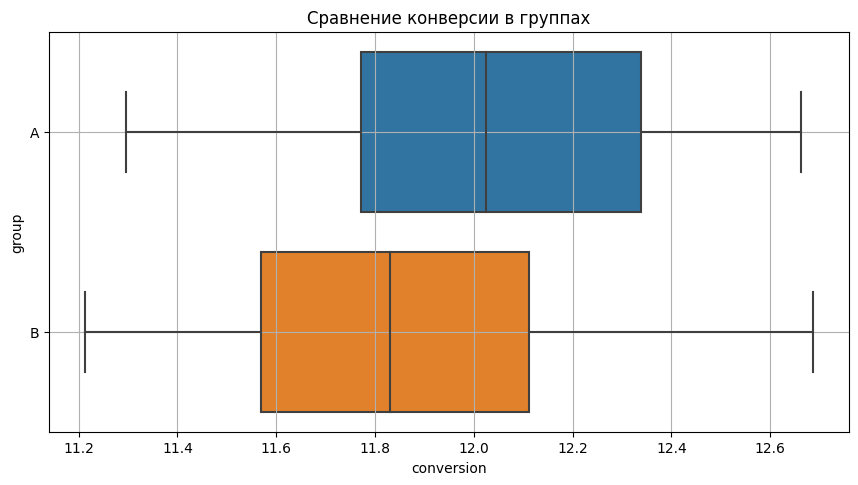

In [7]:
# Создадим фигуры размером 8х4
fig = plt.figure(figsize=(8,4))
# Добавим сетку координат
ax = fig.add_axes([1, 1, 1, 1])
# Строим booxplot для convrsion
sns.boxplot(data=daily_data, x='conversion', y='group')
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

In [8]:
import plotly
import plotly.express as px

In [9]:
fig = px.box(
    data_frame=daily_data,
    x='conversion',
    y='group',
    height=500,
    width=700,
    title='Сравнение конверсии в группах',
    color='group'
)
fig.show()

In [10]:
# Вычислим средную и медиану, для сравнения выборок
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
conversion_piv

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


In [11]:
fig = px.line(
    data_frame= daily_data,
    x='timestamp',
    y='conversion',
    color='group',
    title= 'График конверсии по дням'
)
fig.show()

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [12]:
# Выделим данные для группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей 
daily_data_a.loc[:, 'cum_user_count'] = daily_data_a['user_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'user_count', 'cum_user_count']].head())

C:\Users\Павел\AppData\Local\Temp\ipykernel_11376\568356977.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,timestamp,user_count,cum_user_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


In [13]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['user_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = (daily_data['cum_converted']/ daily_data['cum_users_count'] * 100)
daily_data.head()

,timestamp,group,user_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


In [14]:
fig = px.line(
    data_frame= daily_data,
    x='timestamp',
    y='cum_conversion',
    color='group',
    title= 'График кумулятивной конверсии по дням'
)
fig.show()

### Задания

In [15]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.zip')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.zip')
display(sample_a.head())
display(sample_b.head())

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


,date,cid,transactions,revenue,group
0,2020-11-06,1.000135e+09,0,0,B
1,2020-11-06,1.001648e+09,0,0,B
2,2020-11-06,1.003214e+08,0,0,B
3,2020-11-06,1.003652e+09,0,0,B
4,2020-11-06,1.003833e+09,0,0,B


In [16]:
sample = pd.concat([sample_a, sample_b])

In [17]:
sample['date'] = pd.to_datetime(sample['date'], format='%Y-%m-%d')

In [18]:
daily_sample = sample.groupby(['date', 'group']).agg({
    'cid' : 'count',
    'transactions' : 'sum',
    'revenue' : 'sum'
}).reset_index().rename(columns={'cid' : 'cid_count', 'transactions' : 'sum_transactions', 'revenue' : 'sum_revenue'})
daily_sample.head()

,date,group,cid_count,sum_transactions,sum_revenue
0,2020-11-06,A,2576,16,1577279
1,2020-11-06,B,2499,19,996645
2,2020-11-07,A,2704,23,1721886
3,2020-11-07,B,2804,19,555499
4,2020-11-08,A,3354,25,846051


In [19]:
print(daily_sample[(daily_sample['date'] == '2020-11-08') & (daily_sample['group'] == 'A')])

        date group  cid_count  sum_transactions  sum_revenue
4 2020-11-08     A       3354                25       846051


In [20]:
daily_sample['cum_cid'] = daily_sample.groupby(['group'])['cid_count'].cumsum()
daily_sample['cum_sum_transactions'] = daily_sample.groupby(['group'])['sum_transactions'].cumsum()
daily_sample['cum_sum_revenue'] = daily_sample.groupby(['group'])['sum_revenue'].cumsum()
daily_sample['cum_conversion'] = (daily_sample['cum_sum_transactions'] / daily_sample['cum_cid'])* 100
daily_sample['cum_mean_bil'] = daily_sample['cum_sum_revenue'] / daily_sample['cum_sum_transactions']

In [21]:
round(daily_sample.groupby(['group'])['cum_conversion'].mean(), 2)

group
A    0.71
B    0.76
Name: cum_conversion, dtype: float64

In [22]:
fig = px.line(
    data_frame= daily_sample,
    x='date',
    y='cum_conversion',
    color='group',
    title= 'График кумулятивной конверсии по дням'
)
fig.show()

In [23]:
fig = px.line(
    data_frame= daily_sample,
    x='date',
    y='cum_mean_bil',
    color='group',
    title= 'График кумулятивной конверсии среднего чека по дням'
)
fig.show()

# EDA Анализ результатов А/В тестов. Статистические тесты

In [24]:
# Для проверки гипотезы равенства пропорций мы можем воспользоваться уже знакомым
# нам z-критерием для пропорций. Этот критерий является наиболее популярным для 
# задачи определения статистической значимости изменения конверсии.
from statsmodels.stats.proportion import proportions_ztest

In [25]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


In [26]:
# нулевая и альтернативная гипотеза. так как ранее мы видели что кумулятивный график группы А выше Б проверим это
H0 = 'Конверсии в группах А и В равны'
H1 = 'Конвесия в группе А выше, чем конверсия группы В'
alpha = 0.05 # уровень значимости
# вычисляем значения p-value для z-test пропорции
_, p_value =proportions_ztest(
    count = converted_piv['sum'], # число успехов
    nobs= converted_piv['count'], # общее число наблюдений
    alternative='larger' # smaller, 'two-sided' — двусторонняя, 'smaller' — левосторонняя,
    #'larger' — правосторонняя. По умолчанию параметр равен 'two-sided'. 
)
# выведем результат на экран
print('p_value', round(p_value, 2))

# Сравним полученно p_value с уравнением значимости alpha
if (p_value < alpha):
    print(f'Отвергаем нулевую гипотезу.{H0}')
    print(f'Альтернативная гипотезаю H1 {H1}')
else:
    print(f'Принимаем нулевую гипотезу. H0 {H0}')

p_value 0.1
Принимаем нулевую гипотезу. H0 Конверсии в группах А и В равны


На основе этого вывода мы принимаем решение о том, что делать дальше. Возможные варианты:

* отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить использование текущей версии рекомендаций;
* попытаться усовершенствовать модель и провести тестирование снова;
* использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

### Статистическое тесты для других метрик

In [27]:
# прочтем результаты А/В теста xlsx
time_data = pd.read_excel('data/time_data.xlsx')
time_data.head()

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


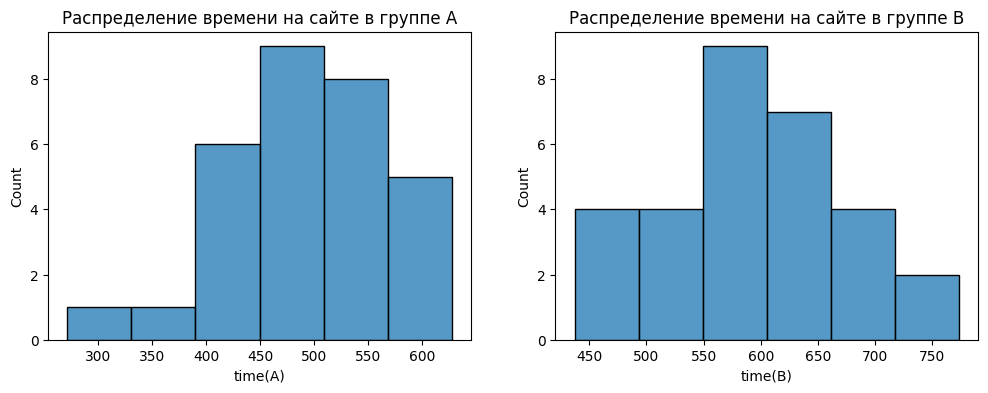

In [28]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

In [29]:
# Проверим распределение на нормально при помощи метода Шапиро-Уилка
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу. {H0}')
    print(f'Альтернативная гипотезаю H1 {H1}')
else:
    print(f'Принимаем нулевую гипотезу {H0}')    

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу Распределения в обеих группах нормальные


Применим T-тест для сравнения средних — функцию *ttest_ind()* из модуля **scipy.stats**. Обратите внимание, что ___левосторонняя альтернативная гипотеза___ в модуле *scipy* указывается в параметре *alternative* как **'less'** (___правосторонняя___ — **'greater'**):

In [30]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

if results.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезую. {H0}')
    print(f'Альтернативная гипотеза H1. {H1}')
else:
    print(f'Принимаем нулеввую гипотезу H0: {H0}')

p-value: 0.0
Отвергаем нулевую гипотезую. Среднее время в группах одинаково
Альтернативная гипотеза H1. Среднее время в группе А меньше, чем в группе B


In [31]:
daily_sample.head()

,date,group,cid_count,sum_transactions,sum_revenue,cum_cid,cum_sum_transactions,cum_sum_revenue,cum_conversion,cum_mean_bil
0,2020-11-06,A,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-06,B,2499,19,996645,2499,19,996645,0.760304,52455.000000
2,2020-11-07,A,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
3,2020-11-07,B,2804,19,555499,5303,38,1552144,0.716576,40845.894737
4,2020-11-08,A,3354,25,846051,8634,64,4145216,0.741256,64769.000000


In [32]:
converted_sample= daily_sample.groupby('group')['cum_conversion'].agg(
    ['sum', 'count']
)
display(converted_sample)

,sum,count
group,,
A,12.829598,18
B,13.719211,18


In [33]:
# нулевая и альтернативная гипотеза. так как ранее мы видели что кумулятивный график группы А выше Б проверим это
H0 = 'Конверсии в группах А и В равны'
H1 = 'Конвесия в группе А меньше, чем конверсия группы В'
alpha = 0.1 # уровень значимости
# вычисляем значения p-value для z-test пропорции
_, p_value =proportions_ztest(
    count = converted_sample['sum'], # число успехов
    nobs= converted_sample['count'], # общее число наблюдений
    alternative='smaller' # smaller, 'two-sided' — двусторонняя, 'smaller' — левосторонняя,
    #'larger' — правосторонняя. По умолчанию параметр равен 'two-sided'. 
)
# выведем результат на экран
print('p_value', round(p_value, 2))

# Сравним полученно p_value с уравнением значимости alpha
if (p_value < alpha):
    print(f'Отвергаем нулевую гипотезу.{H0}')
    print(f'Альтернативная гипотезаю H1 {H1}')
else:
    print(f'Принимаем нулевую гипотезу. H0 {H0}')

p_value 0.37
Принимаем нулевую гипотезу. H0 Конверсии в группах А и В равны


In [34]:
shapiro_sample= daily_sample.groupby('group')['cum_mean_bil']
display(shapiro_sample)

In [35]:
# Проверим распределение на нормально при помощи метода Шапиро-Уилка
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
result_shap_a = shapiro(daily_sample[daily_sample['group'] == 'A']['cum_mean_bil'])
result_shap_b = shapiro(daily_sample[daily_sample['group'] == 'B']['cum_mean_bil'])
print('p-value группы А', round(result_shap_a.pvalue, 2))
print('p-value группы B', round(result_shap_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if result_shap_a.pvalue < alpha or result_shap_b.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу. {H0}')
    print(f'Альтернативная гипотезаю H1 {H1}')
else:
    print(f'Принимаем нулевую гипотезу {H0}')    

p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотезаю H1 Распределение в одной или обеих группах отлично от нормального


In [36]:
from scipy.stats import mannwhitneyu
# нулевая и альтернативная гипотезы
H0 = 'Средние чеки в группе А и группе В равны.'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B.'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Манна-Уитни для выборок
results_mw = mannwhitneyu(
    (daily_sample[daily_sample['group'] == 'A']['cum_mean_bil']), 
    (daily_sample[daily_sample['group'] == 'B']['cum_mean_bil']),
    alternative='less' # при левостороннем неравенстве параметр less правосторонний greater и дву сторонняя two-sided
)
print('p-value:', round(results_mw.pvalue, 2))
if results_mw.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу. {H0}')
    print(f'Альтернативная гипотезаю H1 {H1}')
else:
    print(f'Принимаем нулевую гипотезу {H0}')    

p-value: 0.0
Отвергаем нулевую гипотезу. Средние чеки в группе А и группе В равны.
Альтернативная гипотезаю H1 Ежедневный средний чек в группе А меньше, чем в группе B.


## Анализ результатов A/B-тестирования: доверительные интервалы

Так, мы с вами знаем, что на основе выборки (части наблюдений) мы всегда можем измерить следующие показатели:

* выборочное среднее (центральная мера распределения);
* выборочное стандартное отклонение (мера разброса);
* выборочную пропорцию (доля объектов из выборки, выбранных по условию, например доля пользователей, совершивших покупки).

Однако эти оценки не являются нашим основным предметом интереса. На самом деле нас интересуют параметры генеральной совокупности: 

* истинное среднее — математическое ожидание ($\mu$);
* истинное стандартное отклонение ($\sigma$);
* истинная пропорция ($\rho$).

#### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ ИЗВЕСТНОМ ИСТИННОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

Была опрошена случайная выборка из 36 жителей региона об их затратах на продукты питания за последний месяц. Выборочное среднее оказалось равным 16 100 рублей.
Допустим, откуда-то известно, что истинное стандартное отклонение расходов равно 12 000 рублей.
Нам нужно построить доверительный интервал для истинных средних расходов жителя данного региона на продукты питания в месяц. Интервал должен определять истинное значение с надежностью в 95 %.

Страшно и непонятно? Давайте разбираться. 

По условию задачи у нас есть выборка размером $n=36$ человек. Далее, просуммировав затраты жителей региона и поделив на их количество, было получено выборочное среднее $X_mean = 16100$ рублей. Ещё нам дано значение истинного (НЕ выборочного) стандартного отклонения $\sigma = 12000$ рублей. То есть в среднем разброс затрат составляет 12 000 рублей. Ещё нам сказали, что рассчитанный нами интервал должен быть надёжным с уровнем надёжности $\gamma = 0.95$ .  

In [37]:
n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [38]:
from scipy.stats import norm
z_crit = -norm.ppf(alpha/2)  # Z критичексое

In [39]:
eps = z_crit * sigma/(n ** 0.5) # Погрешность
lower_bond = x_mean - eps # Левая(нижняя) граница интервала
upper_bond = x_mean + eps # Правая (верхняя) граница интервала
confidence_interval = (round(lower_bond), round(upper_bond)) # создаем кортеж из округленных значений
print(f'Доверительный интервал {confidence_interval}') 

Доверительный интервал (12180, 20020)


In [40]:
# ЗАдание
n = 64 # размер выборки
x_mean = 12.35 # выборочное среднее
sigma = 2.4 # истинное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости
z_crit = -norm.ppf(alpha/2) 
print(f'Z_crit = {z_crit}')
eps = round(z_crit, 2) * sigma/(n ** 0.5) # Погрешность
lower_bond = x_mean - eps # Левая(нижняя) граница интервала
upper_bond = x_mean + eps # Правая (верхняя) граница интервала
confidence_interval = (round(lower_bond, 2), round(upper_bond, 2)) # создаем кортеж из округленных значений
print(f'Доверительный интервал {confidence_interval}') 

Z_crit = 1.6448536269514729
Доверительный интервал (11.86, 12.84)


#### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ НЕИЗВЕСТНОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

##### Задача 

Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.
Для оценки управляющий хочет построить доверительный интервал с надёжностью в 95 %.

In [41]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [42]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

In [43]:
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (1778, 2222)


In [44]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (3146, 3934)


### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ПРОПОРЦИИ

In [45]:
ab_data = pd.read_csv('data/ab_data.zip')

In [46]:
# Используем таблицу ab_data, для удобства разделим таблицу на 2 группы
a_data = ab_data[ab_data['group'] == 'A']
b_data = ab_data[ab_data['group'] == 'B']

In [47]:
# Создадим функцию для вычисления инетрвала с 3 аргументами
# n — размер выборки, x_p — выборочная пропорция и gamma — уровень надёжности (по умолчанию он равен 0.95)
def proportions_conf_interval(n, x_p, gamma = 0.95):
    alpha = 1 - gamma # Уровень значимости
    z_crit = -norm.ppf(alpha/2) # z - критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # Левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [48]:
conf_interval_a = proportions_conf_interval(
    n=a_data['user_id'].count(),
    x_p= a_data['converted'].mean()
)
conf_interval_b = proportions_conf_interval(
    n = b_data['user_id'].count(),
    x_p= b_data['converted'].mean()
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


##### Доверительный интервал разницы погрешностей

In [49]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [50]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.39, 0.08)


In [51]:
a = 132/189
dif_a = proportions_conf_interval(189, a, gamma=0.9)
print(round(a, 3), dif_a)

0.698 (64.35, 75.33)


In [52]:
n = 1000
xp_a  = 45/n
xp_b = 50/n


dif_basket = diff_proportions_conf_interval(n=[n, n], xp=[xp_a, xp_b])
dif_basket

(-1.36, 2.36)